In [1]:
from mpc import *

In [2]:
# Total simulation time 24h (1440m)
total_time = 1440  

# Sample time 1m
t_step = 1

# Number of control step total_time/t_step: 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


## Control loop
Control loop for the randomic model.

In [3]:
%%capture

setup_mpc = {
    'n_robust': 1,
    'n_horizon': 10,
    't_step': t_step,
    'store_full_solution': False,
}

toggle = ToggleSwitchRandomicModel(False, LacI_ref, TetR_ref, t_step, total_time, avg_period)
mpc_controller = ControllerMPC(toggle, t_step, setup_mpc, False)
mpc_controller.control_loop(x_0, steps, 'randomic', 1)


## Compute performance metrics and plot results

------------------------------ PERFORMANCES METRICS ------------------------------
ISE: 278.39
ITAE: 3.44e+05
------------------------------ PLOT RESULTS ------------------------------


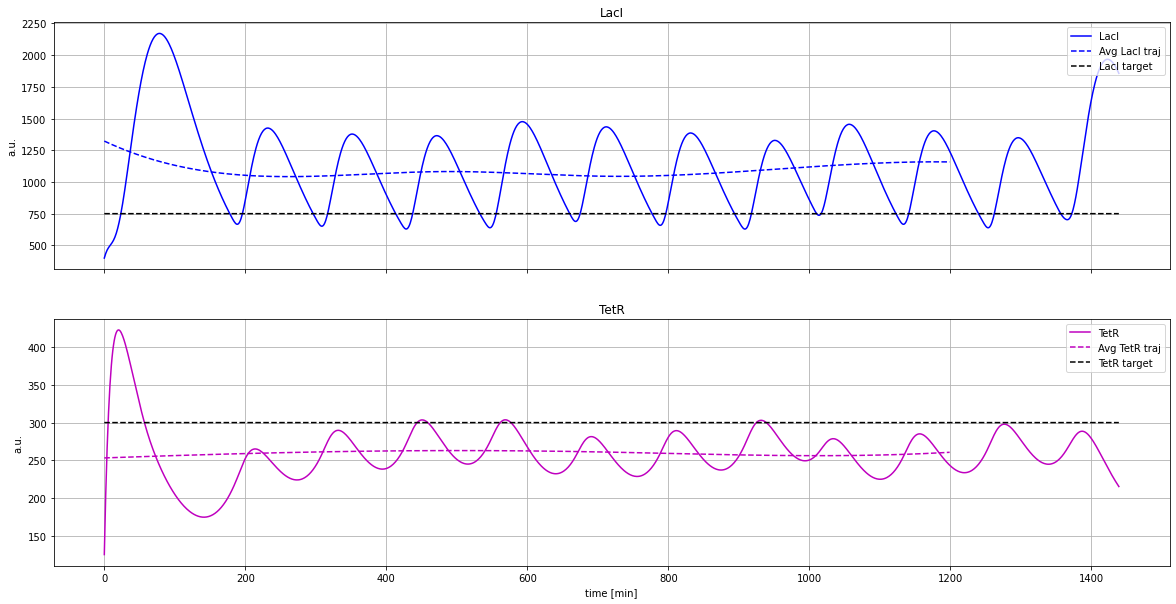

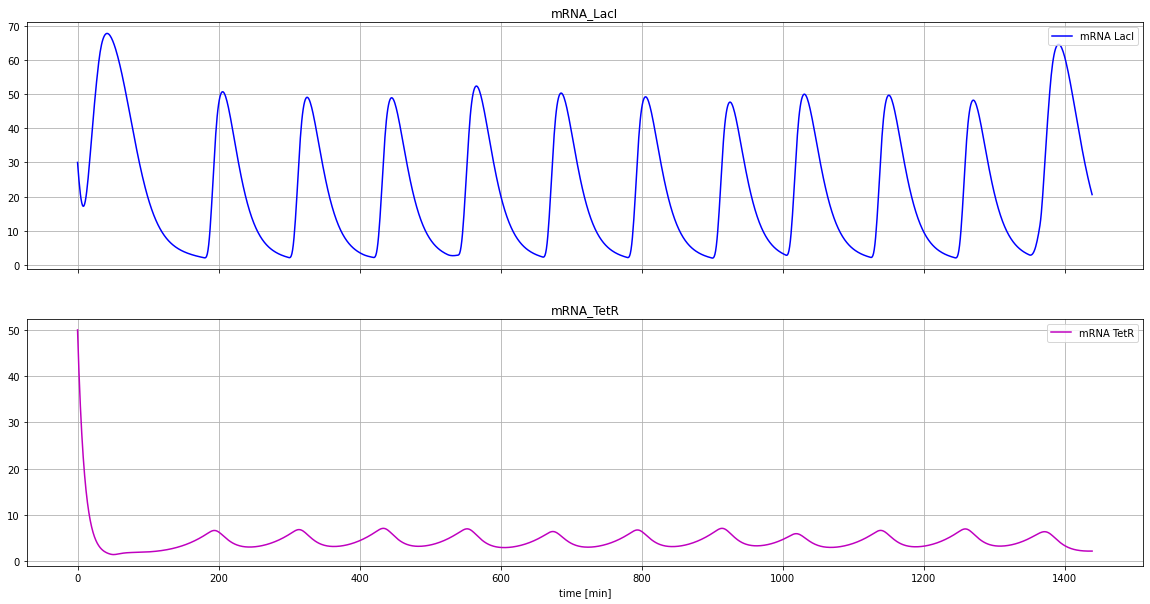

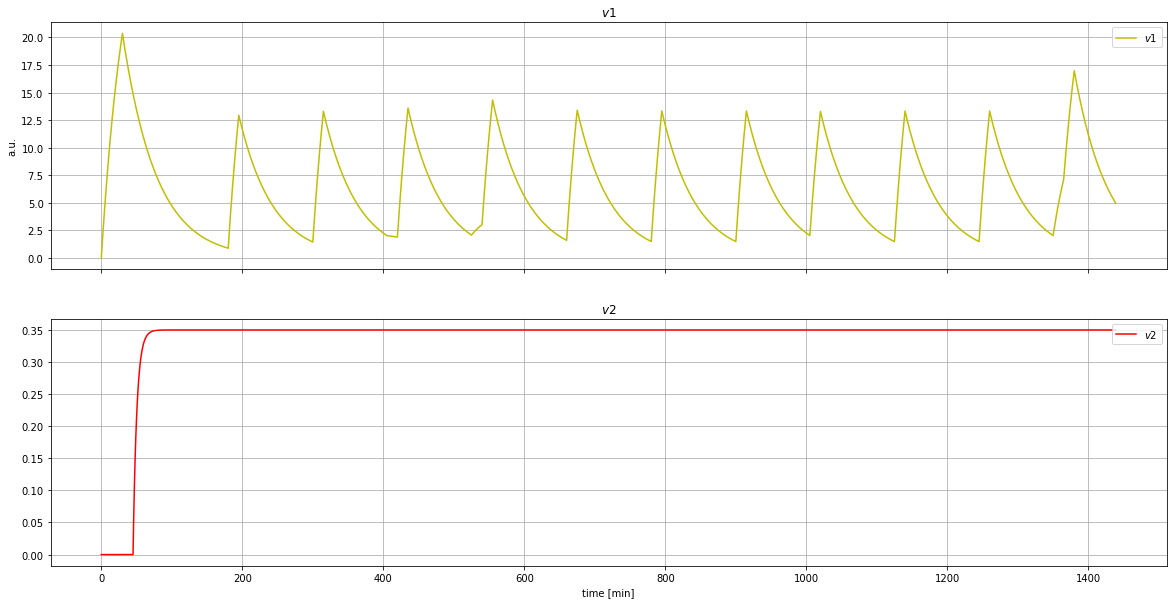

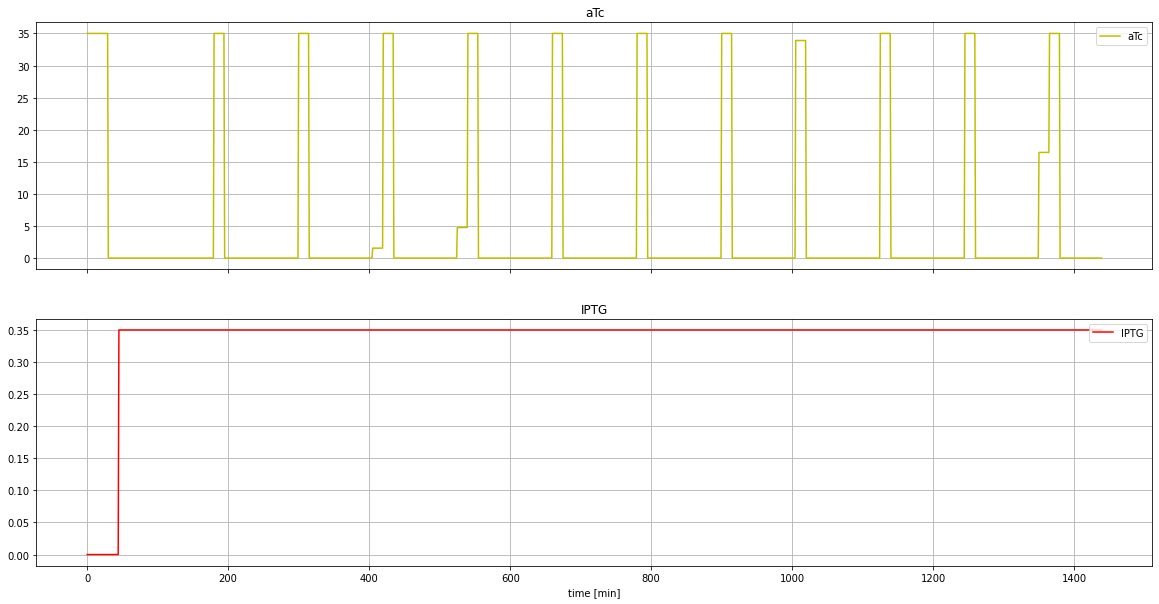

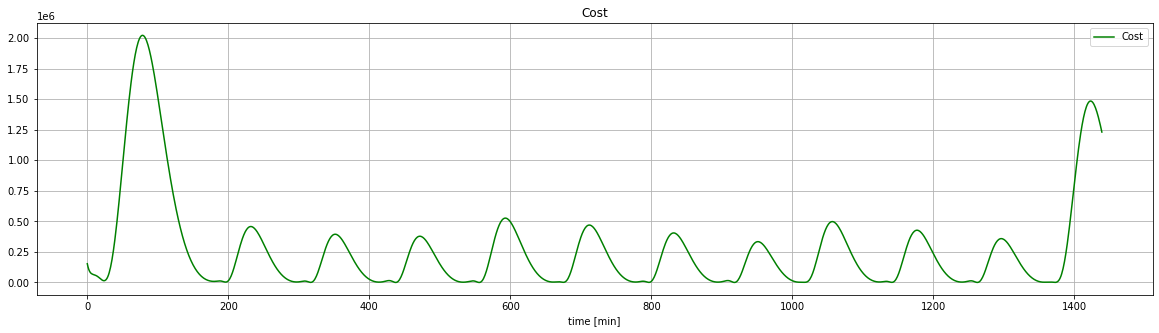

In [4]:
print('------------------------------ PERFORMANCES METRICS ------------------------------')
print('ISE:', "{:.2f}".format(toggle.trajectories['ISE']))
print('ITAE:', format(toggle.trajectories['ITAE'], '.2e'))

print('------------------------------ PLOT RESULTS ------------------------------')
figures, lines = toggle.plot_results()

## Plots animation

In [5]:
toggle.animate_results('randomic', 'proteins', toggle.update_protein, figures[0], (toggle.trajectories, lines[0:6], np.arange(0, total_time - ((total_time-1) % avg_period) - 1, t_step)), steps)
toggle.animate_results('randomic', 'mRNAs', toggle.update_mRNA, figures[1], (toggle.trajectories, lines[6:8]), steps)
toggle.animate_results('randomic', 'internal_inducers', toggle.update_internal_inducers, figures[2], (toggle.trajectories, lines[8:10]), steps)
toggle.animate_results('randomic', 'external_inducers', toggle.update_external_inducers, figures[3], (toggle.trajectories, lines[10:12]), steps)
toggle.animate_results('randomic', 'cost', toggle.update_cost, figures[4], (toggle.trajectories, lines[12:13]), steps)